# Deep Learning Final Project Code - Apple Stock


In [1]:
## CHANGE THIS VALUE TO CODE FOR DESIRED STOCK (ex. Apple Inc. --> "aapl")
# unsure the exact listings the stock news dataset supports
# stock price dataset supports KRX, NASDAQ, NYSE, AMEX, and S&P500 listings
stock_code2use = "aapl"

# convert the code to all caps
stock_code2use = stock_code2use.upper()

In [2]:
# set percent change in closing stock price (up or down) compared with the previous day that constitutes a "large change"
#   should be >=3 for practical reasons, though can be as high as you'd like
percent_cutoff = 4

# Setup

In [3]:
# install packages, if needed
#!pip install datasets
#!pip install openai==0.28
#!pip install finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [4]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
from datasets import load_dataset
import FinanceDataReader as fdr
import openai

In [26]:
## load/test OpenAI API call
openai.api_key='***'

# turn on/off as needed
if False:
  # get user input to feed to ChatGPT
  quest = input("Ask a question: ")

  # feed user input into ChatGPT using their APU
  completion = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
      messages=[
          {'role': 'user', 'content': quest}
      ]
  )

  # print ChatGPT's output
  print(completion['choices'][0]['message']['content'])

# Import and Clean Data

## Stock News Dataset

We could also save the full, cleaned news dataset as a .csv to Google Drive if we wanted to take that approach

In [6]:
# load whole dataset of stock news headlines into a pandas df ("train" is only existing subset)
news_dataset_object = load_dataset("NickyNicky/finance-financialmodelingprep-stock-news-sentiments-rss-feed")
raw_news_df = news_dataset_object["train"].to_pandas()

# print quick details about the whole dataset
print(raw_news_df.columns)
print(raw_news_df.shape)

# extract just the columns for stock code ("symbol"), date of publication, article title, and article text from the raw data
raw_news_df = raw_news_df[['symbol', 'publishedDate', 'title', 'text']]

# convert the "publishedDate" column to a datetime format and rename it to "date"
raw_news_df['publishedDate'] = pd.to_datetime(raw_news_df['publishedDate']).dt.date
raw_news_df.rename(columns={'publishedDate': 'date'}, inplace=True)

# print quick details about the extracted dataset
print(raw_news_df.columns)
print(raw_news_df.shape)
#raw_news_df.info()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/142000 [00:00<?, ? examples/s]

Index(['symbol', 'publishedDate', 'title', 'image', 'site', 'text', 'url',
       'sentiment', 'sentimentScore'],
      dtype='object')
(142000, 9)
Index(['symbol', 'date', 'title', 'text'], dtype='object')
(142000, 4)


In [7]:
## determine range of news dataset
# sort news df by days, showing the oldest and newest dates in the dataset
# it appears the dataset goes from August 12th, 2022 to October 4th, 2023
raw_news_df["date"].sort_values()

141999    2022-08-12
141929    2022-08-12
141930    2022-08-12
141931    2022-08-12
141932    2022-08-12
             ...    
311       2023-10-04
312       2023-10-04
313       2023-10-04
315       2023-10-04
0         2023-10-04
Name: date, Length: 142000, dtype: object

In [8]:
# subset news data to just get stock of interest (note the code must be converted to all upper case)
news_df = raw_news_df[raw_news_df['symbol'] == stock_code2use]
print("This stock ("+stock_code2use+") has "+str(news_df.shape[0])+" total news articles about it in our database.")
print("First four rows of the news dataset for this stock:")
print(news_df.head(4))

This stock (AAPL) has 1221 total news articles about it in our database.
First four rows of the news dataset for this stock:
    symbol        date                                              title  \
188   AAPL  2023-10-04  Stocks edge up as bond selloff takes a break: ...   
367   AAPL  2023-10-04  7 Stocks Warren Buffett Is Loading Up on Befor...   
385   AAPL  2023-10-04  These Apple Insiders Are Selling Shares of AAP...   
441   AAPL  2023-10-04  3 Stocks That Can Withstand a Brutal Stock Mar...   

                                                  text  
188  Wall Street stocks edged up at Wednesday's ope...  
367  Warren Buffett, the legendary investor and CEO...  
385  Apple (NASDAQ:AAPL) stock is a hot topic among...  
441  Concerns about a potential stock market crash ...  


## Stock Prices Dataset

In [9]:
# get the daily stock prices for the given stock as a pandas df, from Aug 12th, 2022 to Oct 4th, 2023 (as these are the dates we have news data for)
# includes open, high, low, close, and volume for each day the exchange was open
raw_price_df = fdr.DataReader(stock_code2use,'2022-8-12','2023-10-04')
price_df = raw_price_df.copy()

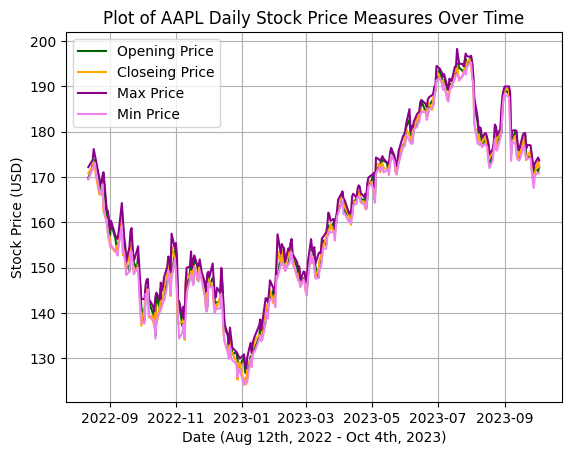

In [10]:
# plot the stock price over the period
plt.plot(price_df['Open'], color="darkgreen", label="Opening Price");
plt.plot(price_df['Close'], color="orange", label="Closeing Price");
plt.plot(price_df['High'], color="darkmagenta", label="Max Price");
plt.plot(price_df['Low'], color="violet", label="Min Price");
plt.title("Plot of "+stock_code2use+" Daily Stock Price Measures Over Time")
plt.xlabel("Date (Aug 12th, 2022 - Oct 4th, 2023)");
plt.ylabel("Stock Price (USD)");
plt.grid();
plt.legend();

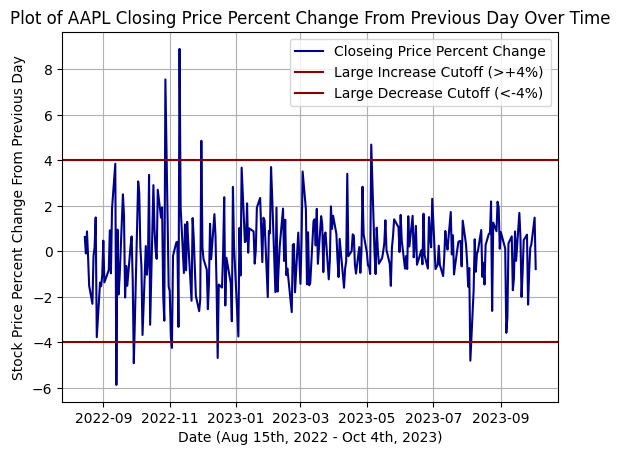

In [11]:
# get closing time percent change from previous day
close_perc_change = (price_df["Close"][1:(price_df.shape[0])].values / price_df["Close"][0:(price_df.shape[0] - 1)].values)
close_perc_change = np.round(close_perc_change*100 - 100, 3)
close_perc_change = pd.Series(close_perc_change)
close_perc_change.index = price_df["Close"][1:len(price_df["Close"])].index

# plot the closing price percent change over the period
plt.plot(close_perc_change, color="darkblue", label="Closeing Price Percent Change");
plt.title("Plot of "+stock_code2use+" Closing Price Percent Change From Previous Day Over Time")
plt.xlabel("Date (Aug 15th, 2022 - Oct 4th, 2023)");
plt.ylabel("Stock Price Percent Change From Previous Day");
plt.grid();
plt.axhline(y=percent_cutoff, color="darkred", label="Large Increase Cutoff (>+"+str(percent_cutoff)+"%)")
plt.axhline(y=(percent_cutoff * -1), color="darkred", label="Large Decrease Cutoff (<-"+str(percent_cutoff)+"%)")
plt.legend();

# Determine Periods of Significant Stock Price Change (Down or Up) For Given Stocks

In [13]:
# get days with a significant increase and decrease in closing stock price
sig_change = close_perc_change[(close_perc_change>percent_cutoff) | (close_perc_change<(percent_cutoff * -1))]
sig_change = pd.DataFrame(sig_change)
sig_change = sig_change.reset_index()
sig_change.columns = ["date", "percent_change"]
sig_change["date"] = pd.to_datetime(sig_change["date"]).dt.date
sig_change["num_articles"] = -1
sig_change["chatgpt_explanation"] = "NA"
print("Number of days classified to have a significant change: "+str(len(sig_change)))
print("Number of days classified to have a significant increase: "+str(sum(sig_change["percent_change"]>0)))
print("Number of days classified to have a significant decrease: "+str(sum(sig_change["percent_change"]<0)))

Number of days classified to have a significant change: 9
Number of days classified to have a significant increase: 4
Number of days classified to have a significant decrease: 5


# Determine Cause of Stock Change From News Data Using ChatGPT

Look at four days prior to day of change through three days after day of change.

(Can adjust these values as desired)

In [14]:
# function to make the ChatGPT call
#"Summary of the Stock Price Change Causes"
def summarize(prompt): #generate summarization function
    model_engine = "text-davinci-003"
    max_tokens = 2000
    completion = openai.Completion.create(
        engine=model_engine,
        prompt=prompt,
        max_tokens=max_tokens,
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0
    )
    message = completion.choices[0].text
    return message.strip()

In [15]:
# set number of days to look at before/after
num_days_prior = 4
num_days_after = 3

In [16]:
# loop through each day of significant change, get news articles, and have ChatGPT come up with an explanation, if there are any news articles
print("Number of days classified to have a significant change: "+str(len(sig_change)))
for sig_date_i in np.arange(sig_change.shape[0]):

  # get number of headlines and explanation of change for given change
  date_start_news = sig_change["date"][sig_date_i] - datetime.timedelta(days=num_days_prior)
  date_end_news = sig_change["date"][sig_date_i] + datetime.timedelta(days=num_days_after)

  # get news data for days close to day of significant change
  news2use = news_df[(news_df["date"] > date_start_news) & (news_df["date"] < date_end_news)]

  # save the number of articles found for the given day of significant change
  sig_change.loc[sig_date_i, "num_articles"] = news2use.shape[0]

  # select columns to feed into ChatGPT
  chatgpt_news_input = news2use[["title", "text"]]

  # use the created function to call ChatGPT, if there is any data to give it
  if sig_change.loc[sig_date_i, "num_articles"] == 0:
    sig_change.loc[sig_date_i, "chatgpt_explanation"] = "[ERROR]: No articles found to feed into ChatGPT"
    print("[ERROR]: No articles found to feed into ChatGPT")
  else:
    # adjust the prompt slightly based on if there was an increase or decrease in the stock price
    if sig_change.loc[sig_date_i, "percent_change"] > 0:
      chatgpt_summary = summarize(f"Analyze the news headlines and articles to determine the cause of the rise in the stock price.\n\n{chatgpt_news_input}")
    else:
      chatgpt_summary = summarize(f"Analyze the news headlines and articles to determine the cause of the drop in the stock price.\n\n{chatgpt_news_input}")

    # save explanation in the dataframe
    sig_change.loc[sig_date_i, "chatgpt_explanation"] = chatgpt_summary

  # wait 21 seconds, as we can only make three ChatGPT requests per minute
  time.sleep(21)

Number of days classified to have a significant change: 9


In [17]:
news2use

,symbol,date,title,text
21781,AAPL,2023-08-06,7 Top Stocks Billionaires Are Loading Up On,"While you might never become a billionaire, yo..."
21788,AAPL,2023-08-06,Inflation and Disney: What to watch this week,The stock market's pristine 2023 rally hit a r...
21817,AAPL,2023-08-05,Buffett's Berkshire Hathaway Swings to $36B Pr...,Company News Earnings Reports and News ...
21825,AAPL,2023-08-05,Apple's $3 Trillion Crown Slips As Disappointi...,Apple Inc's (NASDAQ: AAPL) market value has di...
21980,AAPL,2023-08-04,What's Going On With Nvidia Stock Friday?,Nvidia Corp (NASDAQ: NVDA) stock is trading hi...
21987,AAPL,2023-08-04,Warren Buffett Stocks: What's Inside Berkshire...,"You need to keep up on Warren Buffett stocks, ..."
22024,AAPL,2023-08-04,July Job Market Data Gives the Signal to Buy ‘...,"This week, the seemingly unstoppable stock mar..."
22028,AAPL,2023-08-04,Jim Cramer's top 10 things to watch in the sto...,Amazon's (AMZN) second-quarter results Thursda...
22037,AAPL,2023-08-04,Apple iPhone sales drop more than analysts' es...,Apple (AAPL) announced its fiscal Q3 earnings ...
22042,AAPL,2023-08-04,Apple's Cautiously Navigating Through No Man's...,"Together with Amazon.com Inc (NASDAQ: AMZN), A..."


In [18]:
# set pandas display option to show the full content of each cell, then look at all of the responses
pd.set_option('display.max_colwidth', None)
sig_change
#pd.reset_option('display.max_colwidth', silent=True)

,date,percent_change,num_articles,chatgpt_explanation
0,2022-09-13,-5.868,20,"The cause of the drop in the stock price could be due to a variety of factors. For example, news headlines related to the consolidation in the chip industry, the appointment of a former Apple executive to a credit card startup, an increase in weekly jobless claims, a website and store app briefly looking like ""Craigslist"", mixed reactions to the new iPhone 14, Apple being the first company to assemble smart phones in India, the ratings game for Snap stock, inflation rate and consumer inflation expectations, and Steve Jobs' dispute with Samsung could all have had an impact on the stock price. Additionally, news headlines related to the launch of the iPhone 14, strong demand for the iPhone 14 Pro models, the Emmy Award win for a Netflix game, and Steve Jobs' lack of furniture could have also had an impact on the stock price."
1,2022-09-29,-4.912,34,"The cause of the drop in stock price is likely due to a combination of factors, including fear among US investors, the departure of a key Apple executive, a decrease in US personal consumption expenditures, reports of iPhone production issues, and a downgrade of Apple's stock rating from Bank of America. Additionally, other news such as the removal of Russia's largest social media network from Apple's App Store, as well as a decrease in iPhone demand in China, could have contributed to the drop in stock price."
2,2022-10-28,7.555,32,"The cause of the rise in the stock price can be attributed to several factors. These include Apple's new products, better-than-expected earnings, strong consumer demand, positive analyst reports, and new initiatives. Additionally, the stock price may have been affected by a strong overall market, with other tech stocks also seeing gains."
3,2022-11-03,-4.241,14,"The cause of the drop in the stock price is likely related to news related to Apple's products and services. Specifically, reports of malware attacks on iPhones, speculation about a foldable device by 2024, reports of China's health ministry's severe and disruptive measures to contain the coronavirus, and Apple's lower-than-expected iPhone 14 sales in China could all have contributed to the drop in the stock price. Additionally, news about Apple retaining Qualcomm's 5G modems, the departures of key executives, and Apple's record sales despite missing on iPhone sales could have also impacted the stock price. Finally, the market volatility and the Dow's jump over the 30,000 mark could have factored into the drop in the stock price."
4,2022-11-10,8.897,26,"The cause of the rise in the stock price is likely due to a combination of news related to Apple Inc. (NASDAQ: AAPL). This includes news related to the company's products, such as the iPhone and AirTag, as well as news related to the company's operations, such as its commitment of $450 million for the iPhone 14's satellite project, and its hiring of a startup founder as its information chief. Additionally, news related to Apple's suppliers, such as Foxconn, and news related to the company's competitors, such as Samsung, could also be contributing to the rise in the stock price."
5,2022-11-30,4.859,37,"The cause of the rise in the stock price can vary depending on the particular news headlines and articles. For example, in the case of Apple (AAPL), the cause of the rise in the stock price could be due to news about new products, such as the iPhone 15 series, new features, such as Emergency SOS via satellite, or positive analyst reports. Other news stories, such as the announcement of a new supplier or the launch of a new app, could also cause a rise in the stock price. Additionally, news stories about the company's CEO, such as Elon Musk's feud with Tim Cook, could also cause a rise in the stock price."
6,2022-12-15,-4.685,22,"The cause of the drop in the stock price is likely due to a combination of factors. The headlines and articles point to a variety of issues, incl

## Translation Functions: Transforming Generated Summaries into Spanish, Chinese, and Korean

In [19]:
#helper function to translate English to Spanish
def translate_spanish(text, target_language='es'):
    """
    Translates the given text to the target language using OpenAI GPT-3.

    :param text: The text to be translated.
    :param target_language: The target language code (default is 'es' for Spanish).
    :return: Translated text.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Translate the following English text to {target_language}: {text}",
        max_tokens=1000, # Adjust max_tokens as needed
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        timeout=10  # Set the timeout value in seconds
    )
    return response['choices'][0]['text']

# Assuming you have a DataFrame named 'df' with the provided data
sig_change['chatgpt_explanation_spanish'] = sig_change['chatgpt_explanation'].apply(translate_spanish)


# Assuming df is your DataFrame with the 'chatgpt_explanation_spanish' column
sig_change['chatgpt_explanation_spanish'] = sig_change['chatgpt_explanation_spanish'].str.replace('\n\n', '')


# Display the DataFrame with only the 'chatgpt_explanation_spanish' column
print(sig_change[['chatgpt_explanation_spanish']])


In [20]:
#helper function to translate English to Chinese
def translate_chinese(text, target_language='cn'):
    """
    Translates the given text to the target language using OpenAI GPT-3.

    :param text: The text to be translated.
    :param target_language: The target language code (default is 'es' for Spanish).
    :return: Translated text.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Translate the following English text to {target_language}: {text}",
        max_tokens=1000, # Adjust max_tokens as needed
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        timeout=10  # Set the timeout value in seconds
    )
    return response['choices'][0]['text']

In [21]:
# Assuming you have a DataFrame named 'df' with the provided data
sig_change['chatgpt_explanation_chinese'] = sig_change['chatgpt_explanation'].apply(translate_chinese)


# Assuming df is your DataFrame with the 'chatgpt_explanation_chinese' column
sig_change['chatgpt_explanation_chinese'] = sig_change['chatgpt_explanation_chinese'].str.replace('\n\n', '')

# Display the DataFrame with only the 'chatgpt_explanation_chinese' column
print(sig_change[['chatgpt_explanation_chinese']])

                                                                                                                                                                                                                                                                        chatgpt_explanation_chinese
0                  可能导致股票价格下跌的原因可能有很多因素。例如，有关芯片行业整合的新闻标题、前苹果公司高管被任命为一家信用卡初创公司、每周失业索赔增加、网站和商店应用程序暂时看起来像“Craigslist”、对新款iPhone 14的混合反应、苹果成为第一家在印度组装智能手机的公司、Snap股票评级游戏、通货膨胀率和消费者通货膨胀预期以及史蒂夫·乔布斯与三星的争端都可能会对股票价格产生影响。此外，有关iPhone 14发布、iPhone 14 Pro型号强劲需求、Netflix游戏赢得艾美奖以及史蒂夫·乔布斯缺乏家具的新闻标题也可能会对股票价格产生影响。
1                                                                                                                                               由于多种因素，包括美国投资者的恐惧、苹果关键高管的离职、美国个人消费支出的减少、iPhone生产问题的报道以及美国银行对苹果股票评级的下调，苹果股票价格的下跌可能是由此造成的。此外，把俄罗斯最大的社交媒体网络从苹果应用商店中移除以及中国iPhone需求的减少等其他新闻也可能导致股票价格的下跌。
2                                                                                                                           

In [22]:
#helper function to translate English to Korean
def translate_korean(text, target_language='ko'):
    """
    Translates the given text to the target language using OpenAI GPT-3.

    :param text: The text to be translated.
    :param target_language: The target language code (default is 'es' for Spanish).
    :return: Translated text.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Translate the following English text to {target_language}: {text}",
        max_tokens=1000, # Adjust max_tokens as needed
        n=1,
        stop=None,
        top_p=1,
        temperature=0.5,
        frequency_penalty=0,
        presence_penalty=0,
        timeout=10  # Set the timeout value in seconds
    )
    return response['choices'][0]['text']

In [23]:
# Assuming you have a DataFrame named 'df' with the provided data
sig_change['chatgpt_explanation_korean'] = sig_change['chatgpt_explanation'].apply(translate_korean)


# Assuming df is your DataFrame with the 'chatgpt_explanation_korean' column
sig_change['chatgpt_explanation_korean'] = sig_change['chatgpt_explanation_korean'].str.replace('\n\n', '')

# Display the DataFrame with only the 'chatgpt_explanation_korean' column
print(sig_change[['chatgpt_explanation_korean']])

                                                                                                                                                                                                                                                                                                                                                                                 chatgpt_explanation_korean
0              주가 하락의 원인은 다양한 요인에 의해 발생할 수 있습니다. 예를 들어, 칩 산업 통합과 관련된 뉴스 헤드라인, 신용 카드 스타트업에 애플 이전 인사의 임명, 주간 고용노동자 신고 증가, 웹 사이트와 스토어 앱이 일시적으로 '크래그리스트'와 같아 보이는 것, 새로운 아이폰 14에 대한 혼합된 반응, 인도에서 스마트폰 조립의 첫 주자로 애플, 스냅 주가 등급 게임, 인플레이션 비율과 소비자 인플레이션 예상, 스티브 죠스의 삼성과의 분쟁 등이 모두 주가에 영향을 미칠 수 있었습니다. 또한, 아이폰 14 런칭과 관련된 뉴스 헤드라인, 아이폰 14 프로 모델의 강력한 수요, 넷플릭스 게임의 에미상 수상, 스티브 죠스의 가구 부족 등이 모두 주가에 영향을 미칠 수 있었을 것입니다.
1                                                                                                                                                                                                주가 하락의 원인은 미국 투

## Final output

In [24]:
sig_change.head()

,date,percent_change,num_articles,chatgpt_explanation,chatgpt_explanation_spanish,chatgpt_explanation_chinese,chatgpt_explanation_korean
0,2022-09-13,-5.868,20,"The cause of the drop in the stock price could be due to a variety of factors. For example, news headlines related to the consolidation in the chip industry, the appointment of a former Apple executive to a credit card startup, an increase in weekly jobless claims, a website and store app briefly looking like ""Craigslist"", mixed reactions to the new iPhone 14, Apple being the first company to assemble smart phones in India, the ratings game for Snap stock, inflation rate and consumer inflation expectations, and Steve Jobs' dispute with Samsung could all have had an impact on the stock price. Additionally, news headlines related to the launch of the iPhone 14, strong demand for the iPhone 14 Pro models, the Emmy Award win for a Netflix game, and Steve Jobs' lack of furniture could have also had an impact on the stock price.","La causa de la caída en el precio de las acciones podría deberse a una variedad de factores. Por ejemplo, titulares de noticias relacionados con la consolidación en la industria de chips, la designación de un ex ejecutivo de Apple para una startup de tarjetas de crédito, un aumento en las solicitudes de desempleo semanales, un sitio web y una aplicación de tienda que brevemente se parecían a ""Craigslist"", reacciones mixtas ante el nuevo iPhone 14, Apple siendo la primera empresa en ensamblar teléfonos inteligentes en India, el juego de calificaciones para la acción de Snap, la tasa de inflación y las expectativas de inflación de los consumidores y la disputa de Steve Jobs con Samsung podrían haber tenido un impacto en el precio de las acciones. Además, los titulares de noticias relacionados con el lanzamiento del iPhone 14, la fuerte demanda de los modelos iPhone 14 Pro, el premio Emmy para un juego de Netflix y la falta de muebles de Steve Jobs también podrían haber tenido un impacto en el precio de las acciones.",可能导致股票价格下跌的原因可能有很多因素。例如，有关芯片行业整合的新闻标题、前苹果公司高管被任命为一家信用卡初创公司、每周失业索赔增加、网站和商店应用程序暂时看起来像“Craigslist”、对新款iPhone 14的混合反应、苹果成为第一家在印度组装智能手机的公司、Snap股票评级游戏、通货膨胀率和消费者通货膨胀预期以及史蒂夫·乔布斯与三星的争端都可能会对股票价格产生影响。此外，有关iPhone 14发布、iPhone 14 Pro型号强劲需求、Netflix游戏赢得艾美奖以及史蒂夫·乔布斯缺乏家具的新闻标题也可能会对股票价格产生影响。,"주가 하락의 원인은 다양한 요인에 의해 발생할 수 있습니다. 예를 들어, 칩 산업 통합과 관련된 뉴스 헤드라인, 신용 카드 스타트업에 애플 이전 인사의 임명, 주간 고용노동자 신고 증가, 웹 사이트와 스토어 앱이 일시적으로 '크래그리스트'와 같아 보이는 것, 새로운 아이폰 14에 대한 혼합된 반응, 인도에서 스마트폰 조립의 첫 주자로 애플, 스냅 주가 등급 게임, 인플레이션 비율과 소비자 인플레이션 예상, 스티브 죠스의 삼성과의 분쟁 등이 모두 주가에 영향을 미칠 수 있었습니다. 또한, 아이폰 14 런칭과 관련된 뉴스 헤드라인, 아이폰 14 프로 모델의 강력한 수요, 넷플릭스 게임의 에미상 수상, 스티브 죠스의 가구 부족 등이 모두 주가에 영향을 미칠 수 있었을 것입니다."
1,2022-09-29,-4.912,34,"The cause of the drop in stock price is likely due to a combination of factors, including fear among US investors, the departure of a key Apple executive, a decrease in US personal consumption expenditures, reports of iPhone production issues, and a downgrade of Apple's stock rating from Bank of America. Additionally, other news such as the removal of Russia's largest social media network from Apple's App Store, as well as a decrease in iPhone demand in China, could have contributed to the drop in stock price.","La causa de la baja en el precio de las acciones es probablemente debida a una combinación de factores, incluyendo el temor entre los inversores estadounidenses, la salida de un ejecutivo clave de Apple, una disminución en los gastos de consumo personal de EE. UU., informes de problemas de producción de iPhone y una rebaja de la calificación de las acciones de Apple por parte del Bank of America. Además, otras noticias, como la eliminación de la red social más grande de Rusia de la App Store de Apple, así como una disminución de la demanda de iPhone en China, podrían haber contribuido a la baja en el precio de las acciones.",由于多种因素，包括美国投资者的恐惧、苹果关键高管的离职、美国个人消费支出的减少、iPhone生产问题的报道以及美国银行对苹果股票评级的下调，苹果股票价格的下跌可能是由此造成的。此外，把俄罗斯最大的社交媒体网络从苹果应用商店中移除以及中国iPhone需求的减少等其他新闻也可

In [25]:
## Download the output as a csv file
sig_change.to_csv('Hong_Crim_Final_Project_Result.csv', index=False,encoding='utf-8-sig')